In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import scienceplots
# import pyccl

In [51]:
from scipy.stats import qmc
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, DotProduct, RBF, Matern, RationalQuadratic
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from copy import deepcopy

mcen = np.logspace(11, 16, 50) # unit: Msun/h
# ind = mcen < 10**15
ind = np.linspace(0, 50, 20, dtype=int, endpoint=False)
mcen = mcen[ind]
def ConstructSpaceTest(ntest=50):
    n_param = 8
    cosmo_train = np.load('data/cosmologies_8d_train_n129_Sobol.npy')
    hmf_all = np.load('data/hmf_train_n129_Sobol.npy')[:,ind]
    
    cosmo_valid = np.load('data/cosmologies_8d_validate_n{:d}_LH.npy'.format(ntest))
    hmf_outer = np.load('data/hmf_validate_n{:d}_LH.npy'.format(ntest))[:,ind]
    
    def MyPredicted(para_trainning_in, para_validate_in, Bk_trainning, usePCA=False, **hyperpara):
        ### normalize parameters
        para_min = np.min(para_trainning_in, axis=0)
        para_max = np.max(para_trainning_in, axis=0)
        para_trainning = np.zeros_like(para_trainning_in)
        para_validate  = np.zeros_like(para_validate_in)
        for i_dim in range(para_trainning_in.shape[1]):
            para_trainning[:,i_dim] = (para_trainning_in[:,i_dim] - para_min[i_dim])/(para_max[i_dim]-para_min[i_dim])
            para_validate [:,i_dim] = (para_validate_in [:,i_dim] - para_min[i_dim])/(para_max[i_dim]-para_min[i_dim])

        ###### GP setups
        rand_seed = np.random.RandomState(seed=100318)
        gpr = make_pipeline(preprocessing.StandardScaler(), GaussianProcessRegressor(normalize_y=True, random_state=rand_seed, **hyperpara))
        if usePCA:
            nvec = 6
            pca = PCA(n_components=nvec, svd_solver='full')
            pca.fit(Bk_trainning);
            Bkcoeff = pca.transform(Bk_trainning)
    #         print(Bkcoeff.shape)
            coeff_predited = np.zeros((para_validate.shape[0], nvec))
            for ivec in range(nvec):
                fitting = gpr.fit(para_trainning, Bkcoeff[:,ivec]);
                coeff_predited[:,ivec] = gpr.predict(para_validate);
    #             print("{:d}-th component: ".format(ivec), gpr.kernel_)
            Bk_predited = pca.inverse_transform(coeff_predited);        
        else:
            fitting = gpr.fit(para_trainning, Bk_trainning)
            Bk_predited = gpr.predict(para_validate)
    #     print(gpr.kernel_)
        return Bk_predited

#     kernel = ConstantKernel(1, constant_value_bounds=(1e-15,1e15))*RBF(np.ones((n_param)), length_scale_bounds=(1e-15, 1e15))
#     kernel = RBF(np.ones((n_param)), length_scale_bounds=(1e-15, 1e15)) + DotProduct(10, sigma_0_bounds=(1e-15,1e15))
    kernel = Matern(np.ones((n_param)), length_scale_bounds=(1e-15, 1e15))
    usePCA = True

    # ax0 = plt.subplot(gridp[0, 0])
    n_sample = 33
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                                   Bk_trainning=np.log10(hmf_all[:n_sample,:]/hmf_all[0,:]), 
                                   para_validate_in=cosmo_valid, 
                                   usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    hmf_predicted1 = Bk_predicted*hmf_all[0,:]
    std_predicted1 = np.std(hmf_predicted1/hmf_outer[:,:], axis=0)
    mean_predicted1 = np.mean(hmf_predicted1/hmf_outer[:,:], axis=0)

    n_sample = 65
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                               Bk_trainning=np.log10(hmf_all[:n_sample,:]/hmf_all[0,:]), 
                               para_validate_in=cosmo_valid, 
                               usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    hmf_predicted2 = Bk_predicted*hmf_all[0,:]
    std_predicted2 = np.std(hmf_predicted2/hmf_outer[:,:], axis=0)
    mean_predicted2 = np.mean(hmf_predicted2/hmf_outer[:,:], axis=0)

    n_sample = 129
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                               Bk_trainning=np.log10(hmf_all[:n_sample,:]/hmf_all[0,:]), 
                               para_validate_in=cosmo_valid, 
                               usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    hmf_predicted3 = Bk_predicted*hmf_all[0,:]
    std_predicted3 = np.std(hmf_predicted3/hmf_outer[:,:], axis=0)
    mean_predicted3 = np.mean(hmf_predicted3/hmf_outer[:,:], axis=0)
    return std_predicted1, std_predicted2, std_predicted3, hmf_predicted1, hmf_predicted2, hmf_predicted3

In [52]:
ntest = 50
std_predicted1, std_predicted2, std_predicted3, hmf_pred1, hmf_pred2, hmf_pred3 = ConstructSpaceTest(ntest)


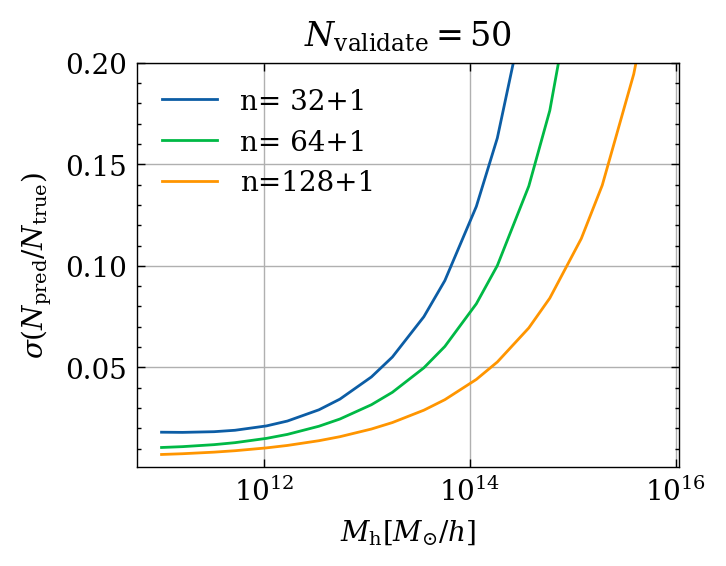

In [53]:
with plt.style.context(['science', 'no-latex']):
    plt.plot(mcen, std_predicted1, label="n= 32+1")
    plt.plot(mcen, std_predicted2, label="n= 64+1")
    plt.plot(mcen, std_predicted3, label="n=128+1")
    plt.xscale('log')
#     plt.yscale('log')
    plt.legend()
    plt.title(r'$N_\mathrm{validate} = %d$'%(ntest))
    plt.grid('on')
    plt.xlabel(r'$M_\mathrm{h} [M_{\odot}/h]$')
    plt.ylabel(r'$\sigma(N_\mathrm{pred}/N_\mathrm{true})$')
    plt.ylim([0.001, 0.2])

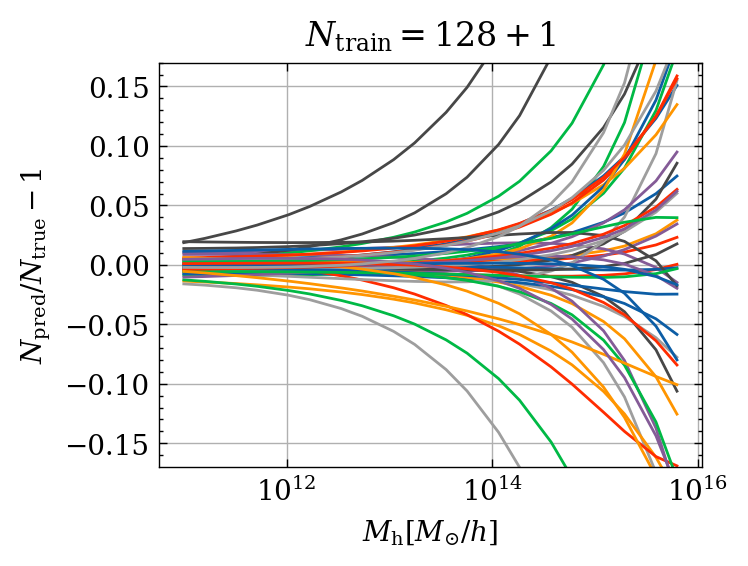

In [55]:
hmf_outer = np.load('data/hmf_validate_n{:d}_LH.npy'.format(ntest))[:,ind]
with plt.style.context(['science', 'no-latex']):
    for ii in range(50):
        plt.semilogx(mcen, hmf_pred3[ii, :]/hmf_outer[ii, :] - 1)
    plt.title(r'$N_\mathrm{train} = %d + 1$'%(128))
    plt.grid('on')
    plt.xlabel(r'$M_\mathrm{h} [M_{\odot}/h]$')
    plt.ylabel(r'$N_\mathrm{pred}/N_\mathrm{true} - 1$')
    plt.ylim([-0.17, 0.17])